In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from glob import glob
import mlflow
import json


In [2]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")
mlflow.set_experiment("CNN_Model")

<Experiment: artifact_location='mlflow-artifacts:/153496007366784002', creation_time=1763701389419, experiment_id='153496007366784002', last_update_time=1763701389419, lifecycle_stage='active', name='CNN_Model', tags={}>

In [3]:
base_path = "C:\\Users\\Sama\\Downloads\\Hand Gesture\\leapGestRecog"

assert os.path.exists(base_path)

subjects = sorted([s for s in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, s))])
print("Total subjects:", len(subjects))

train_subj, test_subj = train_test_split(subjects, test_size=0.2, random_state=42)
print("Train subjects:", train_subj)
print("Test subjects:", test_subj)

Total subjects: 10
Train subjects: ['05', '00', '07', '02', '09', '04', '03', '06']
Test subjects: ['08', '01']


In [4]:
target_dir = "gesture_data_full"
if os.path.exists(target_dir):
    shutil.rmtree(target_dir)
os.makedirs(os.path.join(target_dir, "train"))
os.makedirs(os.path.join(target_dir, "test"))

def copy_subjects(subj_list, subset):
    for subj in subj_list:
        subj_path = os.path.join(base_path, subj)
        for gesture in os.listdir(subj_path):
            src_dir = os.path.join(subj_path, gesture)
            dst_dir = os.path.join(target_dir, subset, gesture)
            os.makedirs(dst_dir, exist_ok=True)
            for img_name in os.listdir(src_dir):
                shutil.copy(os.path.join(src_dir, img_name), os.path.join(dst_dir, img_name))

copy_subjects(train_subj, "train")
copy_subjects(test_subj, "test")

print(" Data folders prepared under:", target_dir)


 Data folders prepared under: gesture_data_full


In [5]:
img_size = (128, 128)
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,           
    width_shift_range=0.2,      
    height_shift_range=0.2,     
    shear_range=0.2,           
    zoom_range=0.2,            
    horizontal_flip=True,
    brightness_range=[0.7, 1.3], 
    channel_shift_range=20.0,   
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(target_dir, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(target_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 16000 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.


In [6]:
num_classes = 10

In [7]:

with mlflow.start_run(run_name="data_preprocessing"):

    # --- Paths & Subjects ---
    mlflow.log_param("base_path", base_path)
    mlflow.log_param("target_dir", target_dir)
    mlflow.log_param("total_subjects", len(subjects))
    mlflow.log_param("train_subjects", str(train_subj))
    mlflow.log_param("test_subjects", str(test_subj))
    mlflow.log_param("num_train_subjects", len(train_subj))
    mlflow.log_param("num_test_subjects", len(test_subj))

    # --- Image Size & Batch ---
    mlflow.log_param("img_size", img_size)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_classes", num_classes)

    # --- Dataset Info ---
    mlflow.log_metric("num_train_images", train_gen.samples)
    mlflow.log_metric("num_test_images", test_gen.samples)


🏃 View run data_preprocessing at: http://127.0.0.1:5000/#/experiments/153496007366784002/runs/81d45339559c48468080e9a443cadf90
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/153496007366784002


In [8]:
with mlflow.start_run(run_name="Data Augmentation"):

    mlflow.log_param("train_datagen_rotation", 25)
    mlflow.log_param("train_datagen_width_shift", 0.2)
    mlflow.log_param("train_datagen_height_shift", 0.2)
    mlflow.log_param("train_datagen_shear", 0.2)
    mlflow.log_param("train_datagen_zoom", 0.2)
    mlflow.log_param("train_datagen_horizontal_flip", True)
    mlflow.log_param("train_datagen_brightness_range", "[0.7,1.3]")
    mlflow.log_param("train_datagen_channel_shift_range", 20.0)
    mlflow.log_param("train_datagen_fill_mode", "nearest")


🏃 View run Data Augmentation at: http://127.0.0.1:5000/#/experiments/153496007366784002/runs/8354c2aa37034689b6ad642ab232794d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/153496007366784002


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    # Block 1
    Conv2D(64, (3,3), activation='relu', padding='same', 
           kernel_regularizer=l2(0.001), input_shape=(*img_size, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),
    
    # Block 2
    Conv2D(128, (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),
    
    # Block 3
    Conv2D(256, (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.4),
    
    # Block 4
    Conv2D(512, (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.5),
    
    GlobalAveragePooling2D(),
    
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(num_classes, activation='softmax')
])
model.summary()

c:\Users\Sama\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,02

 Total params: 1,954,442 (7.46 MB)

 Trainable params: 1,950,986 (7.44 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [10]:
model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


# Callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_gesture_full.keras", save_best_only=True, verbose=1),
    ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-7, verbose=1)
]

In [12]:
from sklearn.utils.class_weight import compute_class_weight

# Class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weight_dict = dict(enumerate(class_weights))


In [13]:
import mlflow.keras

with mlflow.start_run(run_name="CNN_Full_Model"):

    # -----------------------------
    # Log key parameters
    # -----------------------------
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("learning_rate", 5e-4)
    mlflow.log_param("loss_function", "categorical_crossentropy")
    mlflow.log_param("epochs", 40)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_classes", num_classes)
    mlflow.log_param("class_weighting", True)
    
    # -----------------------------
    # Train the model
    # -----------------------------
    history = model.fit(
        train_gen,
        validation_data=test_gen,
        epochs=1,
        callbacks=callbacks,
        class_weight=class_weight_dict
    )
    
    # -----------------------------
    # Log metrics
    # -----------------------------
    for i, acc in enumerate(history.history['accuracy']):
        mlflow.log_metric("train_accuracy", acc, step=i+1)
    for i, val_acc in enumerate(history.history['val_accuracy']):
        mlflow.log_metric("val_accuracy", val_acc, step=i+1)
    for i, loss in enumerate(history.history['loss']):
        mlflow.log_metric("train_loss", loss, step=i+1)
    for i, val_loss in enumerate(history.history['val_loss']):
        mlflow.log_metric("val_loss", val_loss, step=i+1)
    
    # -----------------------------
    # Log the trained model
    # -----------------------------
    mlflow.keras.log_model(model, artifact_path="cnn_full_model", registered_model_name="CNN_Full_Gesture_Model")


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1879 - loss: 4.1424
Epoch 1: val_loss improved from None to 7.58954, saving model to best_gesture_full.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 698s 1s/step - accuracy: 0.3049 - loss: 3.5908 - val_accuracy: 0.1937 - val_loss: 7.5895 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 1.


2025/11/28 21:45:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/28 21:45:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/28 21:45:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'CNN_Full_Gesture_Model' already exists. Creating a new version of this model...
2025/11/28 21:45:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: CNN_Full_Gesture_Model, version 2


🏃 View run CNN_Full_Model at: http://127.0.0.1:5000/#/experiments/153496007366784002/runs/c815136c1f2843d4b03d7acb717f0359
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/153496007366784002


Created version '2' of model 'CNN_Full_Gesture_Model'.


In [14]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)

y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred_classes, target_names=class_labels))


125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 275ms/step - accuracy: 0.1937 - loss: 7.5895
Test Accuracy: 0.19374999403953552
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 257ms/step
               precision    recall  f1-score   support

      01_palm       0.00      0.00      0.00       400
         02_l       0.00      0.00      0.00       400
      03_fist       0.11      0.07      0.09       400
04_fist_moved       0.26      0.38      0.31       400
     05_thumb       0.00      0.00      0.00       400
     06_index       0.00      0.00      0.00       400
        07_ok       0.00      0.00      0.00       400
08_palm_moved       0.13      1.00      0.24       400
         09_c       0.00      0.00      0.00       400
      10_down       1.00      0.49      0.66       400

     accuracy                           0.19      4000
    macro avg       0.15      0.19      0.13      4000
 weighted avg       0.15      0.19      0.13      4000



c:\Users\Sama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

In [15]:
with mlflow.start_run(run_name="Evaluation", nested=True):  # nested=True if training run already exists

    # Log test metrics
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("test_loss", test_loss)

    
    report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)
    with open("classification_report.json", "w") as f:
        json.dump(report, f)
    mlflow.log_artifact("classification_report.json")


c:\Users\Sama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

🏃 View run Evaluation at: http://127.0.0.1:5000/#/experiments/153496007366784002/runs/7afa4b36fd19432ea633a47e1d4d4c02
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/153496007366784002


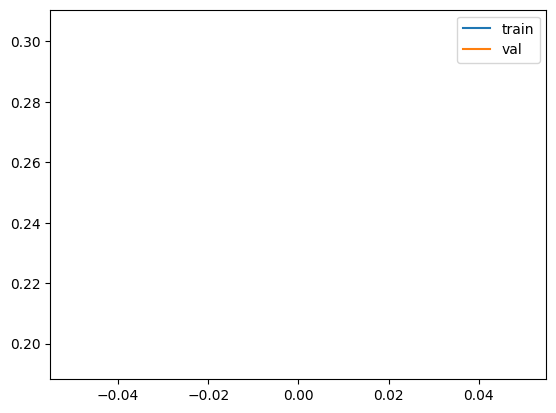

In [20]:


import matplotlib.pyplot as plt 
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.legend(['train', 'val']) 
plt.show()

In [17]:
with mlflow.start_run(run_name="training_curves"):
    mlflow.log_artifact("accuracy_plot.png", artifact_path="plots")

🏃 View run training_curves at: http://127.0.0.1:5000/#/experiments/153496007366784002/runs/edd3b4c1ea964275a131972759e72c9a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/153496007366784002


125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 256ms/step


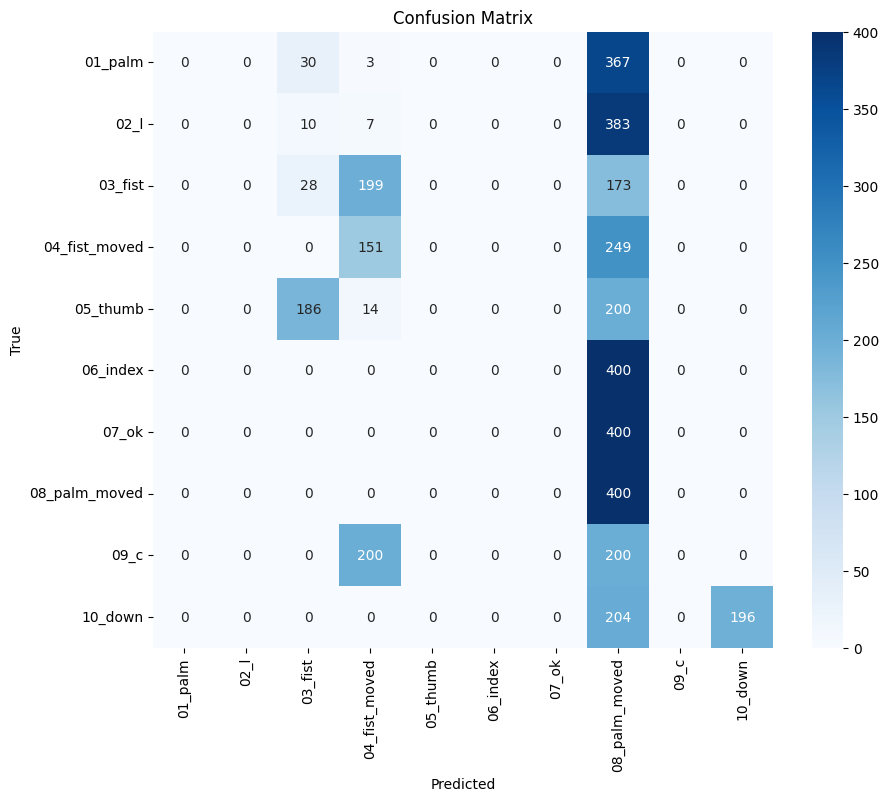

🏃 View run confusion_matrix_plot at: http://127.0.0.1:5000/#/experiments/153496007366784002/runs/cbf2492f614a4e73ae01bc1a66b91ef8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/153496007366784002


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on test set
y_pred = model.predict(test_gen)
y_true = test_gen.classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_gen.class_indices.keys()),
            yticklabels=list(test_gen.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")

plt.show()

with mlflow.start_run(run_name="confusion_matrix_plot"):
    mlflow.log_artifact("confusion_matrix.png", artifact_path="plots")